In [1]:
#pip install tensorflow
import sys
!{sys.executable} -m pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
file_path = "data/RawTelcoData.csv"

df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#DATA LOADER
def load_data(filepath):
    """
    reads csv file
    input: file path
    output: pandas dataframe
    """
    df = pd.read_csv(filepath)
    print(f"Shape of DF: {df.shape} (rows, cols")
    return df

#DATA EXPLORATION
def explore_data(df):
    """
    checks for:
    1. info
    2. missing values
    3. target balance
    4. specific data type check
    """
    #info, summary of the table
    print("\nDATA INFO:")
    print(df.info())

    #missing values
    print("\nMISSING VALUES:")
    print(df.isnull().sum())

    #balance of target variable (churn)
    #important as we need to know if no. of 'yes' or 'no' is equal
    print("\nTARGET BALANCE (CHURN)")
    print(df["Churn"].value_counts(normalize = True))

    #check specific data (total charges)
    #from df.info(), TotalCharges should be float instead of an object
    print("\nSPECIFIC DATA TYPE CHECK")
    if "TotalCharges" in df.columns:
        if df['TotalCharges'].dtype == "object":
            print("TotalCharges is an object")
            #convert to numeric, count how many fail to convert(might be empty)
            non_numeric_count = pd.to_numeric(df["TotalCharges"], errors = "coerce").isnull().sum()
            print(f"Count of non-numeric rows: {non_numeric_count}")
        else:
            print("TotalCharges is numeric")

In [5]:
"""
from data exploration, there are no missing values found,
Churn is not balanced so will have to adjust class weights later on. (73.462% NO, 26.537 YES)
for TotalCharges, there are 11 non-numeric rows
"""

'\nfrom data exploration, there are no missing values found,\nChurn is not balanced so will have to adjust class weights later on. (73.462% NO, 26.537 YES)\nfor TotalCharges, there are 11 non-numeric rows\n'

In [6]:
#DATA VISUALIZATION
def visualize_eda(df, target_col = "Churn"):
    """
    generates plots for all variable against churn
    """
    sns.set(style="whitegrid")

    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    #since were running visualize before cleaning, "TotalCharges" still has empty ' '
    #adding a temporary copy of the data to convert first so can visualize, cleaning will be done later
    df_visualize = df.copy()
    for col in numeric_cols:
        if col in df_visualize.columns:
            df_visualize[col] = pd.to_numeric(df_visualize[col], errors='coerce')
    
    categorical_cols = [col for col in df.columns if col not in numeric_cols and col != target_col]

    #numerical
    for col in numeric_cols:
        plt.figure(figsize=(14, 5))
        
        # plot 1: histogram (checks for skewness)
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=col, kde=True, hue=target_col, element="step")
        plt.title(f'Distribution of {col} (Skewness Check)')
        
        # plot 2: box plot (checks for outliers & relation to churn)
        plt.subplot(1, 2, 2)
        sns.boxplot(x=target_col, y=col, data=df, palette='Set2')
        plt.title(f'{col} vs. {target_col} (Outlier Check)')
        
        plt.tight_layout()
        plt.show()

    #categorical
    num_rows = math.ceil(len(categorical_cols) / 2)
    plt.figure(figsize=(16, 5 * num_rows))
    
    for i, col in enumerate(categorical_cols):
        plt.subplot(num_rows, 2, i + 1)
        
        sns.countplot(x=col, hue=target_col, data=df, palette='viridis')
        plt.title(f'Churn Rates by {col}')
        plt.legend(title='Churn', loc='upper right')
        plt.xticks(rotation=45) # rotate labels if they are long
        
    plt.tight_layout()
    plt.show()

    #correlation heatmap
    plt.figure(figsize=(8, 6))
    corr = df_visualize[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
        

    

In [7]:
#DATA CLEANING
def clean_data(df):
    """
    cleans df:
    1. changes TotalCharge to numeric
    2. Drops irrelevant cols
    3. encode categorical
    """

    #fix TotalCharges
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce") #coerce coverts non numeric text to NaN
    df["TotalCharges"] = df["TotalCharges"].fillna(0) #fills converted NaNs to 0

    #drop customerID (noise)
    if "customerID" in df.columns:
        df = df.drop(columns = ["customerID"])

    #simplify "No Internet Service " to "No"
    cols_to_replace = [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ]

    for col in cols_to_replace:
        if col in df.columns:
            df[col] = df[col].replace({"No Internet Service": "No"})

    #simplify "No Phone Service" to "No"
    if "MultipleLines" in df.columns:
        df["MultipleLines"] = df["MultipleLines"].replace({"No Phone Service": "No"})

    #binary encoding (yes no -> 1 0)
    yes_no_cols = [
        "Partner",
        "Dependents",
        "PhoneService",
        "MultipleLines",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
        "PaperlessBilling",
        "Churn"
    ]

    for col in yes_no_cols:
        if col in df.columns:
            df[col] = df[col].replace({"Yes": 1, "No": 0})

    #one-hot encode categoricals
    df = pd.get_dummies(df, drop_first=True)

    df = df.astype(float)

    return df

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#SPLITTING AND SCALING
def split_and_scale(df, target_col = "Churn"):
    """
    split data into train/test, scales numerical features
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    #split data 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    #scale numeric col
    cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = MinMaxScaler()

    X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape:  {X_test.shape}")

    return X_train, X_test, y_train, y_test

In [9]:
if __name__ == "__main__":
    file_path = "data/RawTelcoData.csv"

    #1. load
    df = load_data(file_path)

    #2. explore
    if df is not None:
        explore_data(df)

    # #3. visualize
    # visualize_eda(df)

    #4. clean
    df_clean = clean_data(df)

    #5. split and scale
    X_train, X_test, y_train, y_test = split_and_scale(df_clean)

 

    print(df_clean.head())
    print(df_clean.dtypes)

Shape of DF: (7043, 21) (rows, cols

DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 

/var/folders/6w/dytfq45576ldxw8pq312lp5c0000gn/T/ipykernel_65567/961122070.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Yes": 1, "No": 0})


In [10]:
#MODEL ARCHITECTURE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def model_creation(input_dimension):
    model = Sequential()

    #input & 1st layer
    model.add(Dense(16, activation="relu", input_dim = input_dimension))

    #dropout
    #randomly disables 20% of neurons during training to prevent overfit
    model.add(Dropout(0.2))

    #layer 2
    model.add(Dense(8, activation = "relu"))

    #output layer
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(optimizer = Adam(learning_rate = 0.001),
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])
    return model
    

In [11]:
if __name__ == "__main__":
    if "X_train" in locals():
        n_features = X_train.shape[1]
        model = model_creation(n_features)
        print("MODEL SUMMARY:")
        model.summary()

MODEL SUMMARY:


/opt/anaconda3/envs/churn_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#MODEL TRAINING (updated with oversampling)
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

def train_model(X_train, y_train):
    tf.random.set_seed(42)
    np.random.seed(42)

    #SMOTE
    print(f"ORIGINAL CLASS DISTRIBUTION: {y_train.value_counts().to_dict()}")
    smote = SMOTE(random_state = 42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"RESAMPLED CLASS DISTRIBUTION: {y_train_resampled.value_counts().to_dict()}")

    n_features = X_train.shape[1]
    model = model_creation(n_features)

    #divide learning rate by 2 if doesnt improve for 3 epochs
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=0.00001, 
        verbose=1
    )

    #implemented early stopping for overfit
    early_stop = EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True,
        verbose = 1
    )

    print("TRAINING START")
    history = model.fit(
        X_train_resampled, y_train_resampled,
        epochs = 100,
        batch_size = 32,
        validation_split = 0.2,
        verbose = 1,
        callbacks = [reduce_lr, early_stop]
    )

    print("TRAINING COMPLETE")
    return model, history

def loss_accuracy_plot(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize = (12,4))

    #accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    save_dir = "plots"
    filename = "training_performance.png"
    filepath = os.path.join(save_dir, filename)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if os.path.exists(filepath):
        print(f"delete old plot: {filepath}")

    plt.savefig(filepath)
    print(f"saved new plot to: {filepath}")

    plt.show()

ORIGINAL CLASS DISTRIBUTION: {0.0: 4139, 1.0: 1495}
RESAMPLED CLASS DISTRIBUTION: {0.0: 4139, 1.0: 4139}
TRAINING START
Epoch 1/100


/opt/anaconda3/envs/churn_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.6986 - loss: 0.5624 - val_accuracy: 0.7120 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7611 - loss: 0.4994 - val_accuracy: 0.7385 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.7652 - loss: 0.4882 - val_accuracy: 0.7500 - val_loss: 0.6217 - learning_rate: 0.0010
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7653 - loss: 0.4827 - val_accuracy: 0.7446 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.7723 - loss: 0.4760 - val_accuracy: 0.7440 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.7773 - loss: 0.4728 - val_accuracy: 0.7488 - val_loss: 0.6077 - learning_rate: 0.0010
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.7753 - loss: 

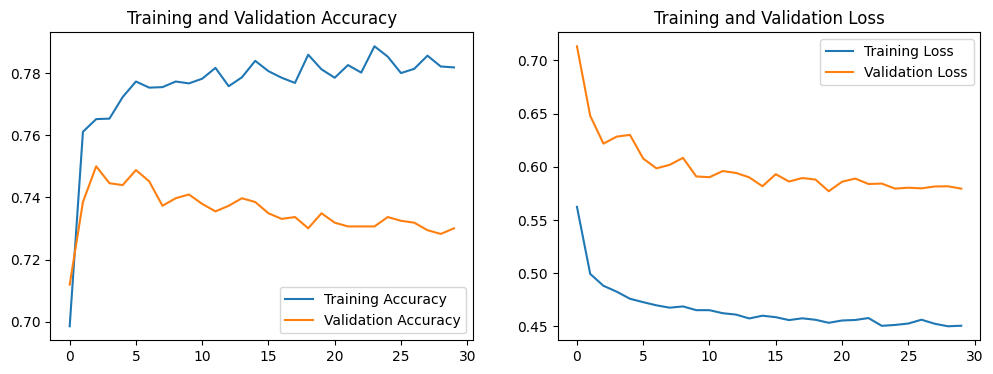

In [13]:
if __name__ == "__main__":
    if "X_train" in locals() and "y_train" in locals():
        model, history = train_model(X_train, y_train)
        loss_accuracy_plot(history)


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#MODEL EVALUATION
def eval_model(model, X_test, y_test, threshold):
    """
    generates final performance report
    1. confusion matrix
    2. precision, recall, F1
    3. roc-auc score 
    """

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)

    print("CONFUSION MATRIX")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print("\nCLASSIFICATION REPORT (PRECISION, RECALL, F1)")
    print(classification_report(y_test, y_pred))

    print("\nROC-AUC SCORE")
    roc = roc_auc_score(y_test, y_pred_probs)
    print(f"ROC-AUC: {roc:.4f}")

In [23]:
#THRESHOLD TUNING
from sklearn.metrics import f1_score, precision_score, recall_score

def optimal_threshold(model, X_test, Y_test):
    """
    Scans threshold from 0 - 1 to find the best F1 score
    plots precision recall trade-off curve
    """

    y_pred_probs = model.predict(X_test)

    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []
    precisions = []
    recalls = []

    for t in thresholds:
        y_pred = (y_pred_probs > t).astype(int)

        p = precision_score(y_test, y_pred, zero_division = 0)
        r = recall_score(y_test, y_pred, zero_division = 0)
        f1 = f1_score(y_test, y_pred, zero_division = 0)

        precisions.append(p)
        recalls.append(r)
        f1_scores.append(f1)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"BEST THRESHOLD: {best_threshold:.2f}")
    print(f"MAX F1 SCORE: {best_f1:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', linestyle='--', color='blue', alpha=0.7)
    plt.plot(thresholds, recalls, label='Recall', linestyle='--', color='orange', alpha=0.7)
    plt.plot(thresholds, f1_scores, label='F1 Score (Balance)', linewidth=3, color='green')

    plt.axvline(best_threshold, color='red', linestyle=':', label=f'Optimal ({best_threshold:.2f})')

    plt.title('Precision-Recall Trade-off & Optimal F1 Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_threshold

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
CONFUSION MATRIX


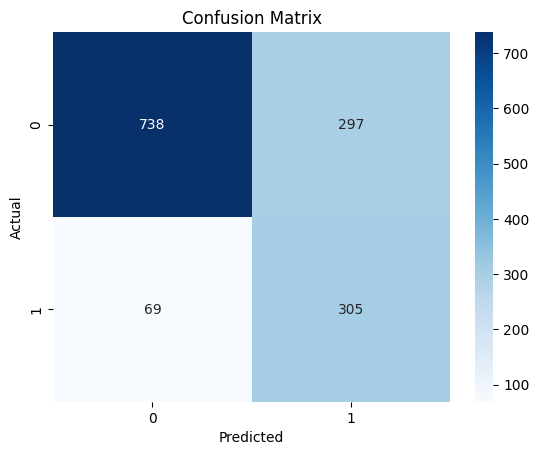


CLASSIFICATION REPORT (PRECISION, RECALL, F1)
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      1035
         1.0       0.51      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.75      1409


ROC-AUC SCORE
ROC-AUC: 0.8403


In [24]:
if __name__ == "__main__":
    if 'model' in locals() and 'X_test' in locals():
        eval_model(model, X_test, y_test, threshold = 0.36)

        #only run this once to find optimal threshold then hardcode it
        # best_thresh = optimal_threshold(model, X_test, y_test)